In [316]:
using Plots
using StatsBase
using Statistics
pyplot()

using DSP

include("ARMA_Generator.jl")
include("wiener_filter_scalar.jl")

wiener_filter (generic function with 1 method)

In [317]:
# Graph stuff
Nex = 2^10;
Theta = 2pi*(0:Nex)/Nex;
Z = map(th -> exp(im*th),Theta);

So far it was tested with 

`
steps = 10^4
discard = 10^3
l = [1, -5/4, 3/8]
pred = ARMA_gen(l, steps = steps)
w = [1, -5/3, 4, -20/3];
sig = ARMA_gen([],w, steps = steps);
`

And with 

`
steps = 10^4
discard = 10^3
Zeros = [-.2im .2im .8]
Poles = [.5im -.5im .6]
pred = ARMA_gen(Zeros = Zeros, Poles = Poles, steps = steps, discard = discard)
Zeros = [.8]
Poles = [.33im -.33im .2]
sig = ARMA_gen(Zeros = Zeros, Poles = Poles, steps = steps, discard = discard)
`

Then with 

`
steps = 10^4
discard = 10^3
p, q = 5 , 6
Zeros_pred = 1 .- rand(q)*2
Poles_pred = 1 .- rand(p)*2
pred = ARMA_gen(Zeros = Zeros_pred, Poles = Poles_pred, steps = steps, discard = discard)
p, q = 3 , 6
Zeros_sig = 1 .- rand(q)*2
Poles_sig = 1 .- rand(p)*2
sig = ARMA_gen(Zeros = Zeros_sig, Poles = Poles_sig, steps = steps, discard = discard)
`

Here we build WSS processes to test the WF.

In [318]:
steps = 10^6
discard = 10^4

r = 1.0
Zeros_sig = [] #1 .- rand(q)*2
Poles_sig = [-.2, .6] #1 .- rand(p)*2
sig = ARMA_gen([1], r = r, Zeros = Zeros_sig, Poles = Poles_sig, steps = steps, discard = discard)
sig_test = ARMA_gen([1],r = r, Zeros = Zeros_sig, Poles = Poles_sig, steps = steps, discard = discard);

P_sig = prod([Poly([1]); [Poly([1,-z]) for z in Poles_sig]])
Q_sig = prod([Poly([1]); [Poly([1,-z]) for z in Zeros_sig]])
tranfer_fun(z) = Q_sig(z^(-1))/P_sig(z^(-1))

tranfer_fun (generic function with 1 method)

In [319]:
eps = 1
w = [1, -5/4, 3/8]
pred = conv(w,sig)[discard + 1 : steps] .+ eps*randn(steps-discard);
sig = sig[discard + 1 : steps];
pred_test = conv(w,sig_test)[discard + 1 : steps] .+ eps*randn(steps-discard);
sig_test = sig_test[discard + 1 : steps];

In [320]:
p = [1, -0.4, -0.21]

W(z) = Poly(w)(z^(-1))
W_star(z) = Poly(reverse(w))(z^(-1))
P(z) = Poly(p)(z^(-1))
P_star(z) = Poly(reverse(p))(z^(-1))
S_X_numr = Poly(w)*Poly(reverse(w))+Poly(p)*Poly(reverse(p))
S_X_denr = Poly(p)*Poly(reverse(p))
r = roots(S_X_numr)

4-element Array{Float64,1}:
 10.109052097951267  
  1.419244721571023  
  0.7046001192049924 
  0.09892124309089909

In [321]:
rho = roots(S_X_denr)

4-element Array{Float64,1}:
 -3.3333333333333286 
  1.4285714285714295 
  0.6999999999999992 
 -0.30000000000000004

In [355]:
r1,r2 = r[1:2]
rr = r1*r2

rho1, rho2 = rho[1:2]
rrho = rho[1]*rho[2]

s = sqrt(33/14*rrho/rr+0*im)

0.0 + 0.8845032714209574im

In [356]:
par = 55

z_spect_sig_ana(z) = abs(tranfer_fun(z))^2
z_spect_sig_num = z_spect(sig,par, win = "Par")

z_spect_pred_minus_ana(z) = s*(r1 - z^(-1))*(r2 - z^(-1))/((rho1 - z^(-1))*(rho2 - z^(-1)))
z_spect_pred_plus_ana(z) = conj( z_spect_pred_minus_ana( conj(z)^(-1) ) )
z_spect_pred_ana(z) = z_spect_pred_minus_ana(z)*z_spect_pred_plus_ana(z)
z_spect_pred_num = z_spect(pred,par, win = "Par")

z_crossspect_sigpred_ana(z) = z_spect_sig_ana(z)*conj( W( conj(z)^(-1) ) )
z_crossspect_sigpred_num = z_crossspect(sig, pred, par, win = "Par")

M = par
R_pred    = autocov(pred,0:M);

#     Smoothing
LL = Int(floor(M/2))
lam1 = 1 .- 6*((0:LL)/M).^2 .+ 6*((0:LL)/M).^3
lam2 = 2*(1 .- (LL+1:M)/M).^3
lam = [lam1; lam2];

R_pred = R_pred.*lam
l = Scalar_CKMS_c(R_pred);

z_spect_pred_minus_num(z) = sum([l[i+1]z^(-i) for i = 0:M])
z_spect_pred_plus_num(z) = z_spect_pred_minus_num(z)'

z_spect_pred_plus_num (generic function with 1 method)

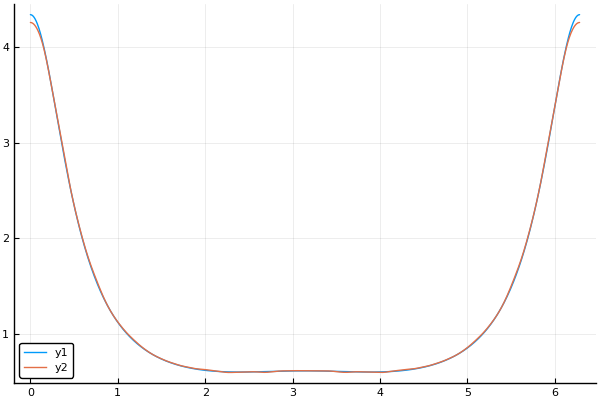

In [352]:
plot(Theta, [z_spect_sig_ana.(Z) real.(z_spect_sig_num.(Z))])

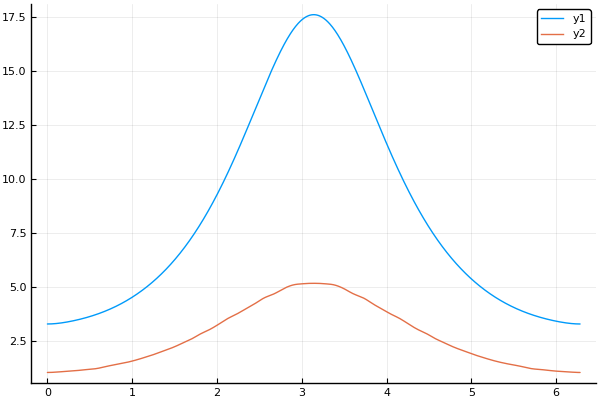

In [357]:
z_spect_pred_NUM(z) = z_spect_pred_minus_num(z)*z_spect_pred_plus_num(z)
plot(Theta, [real.(z_spect_pred_ana.(Z)) real.(z_spect_pred_num.(Z))])

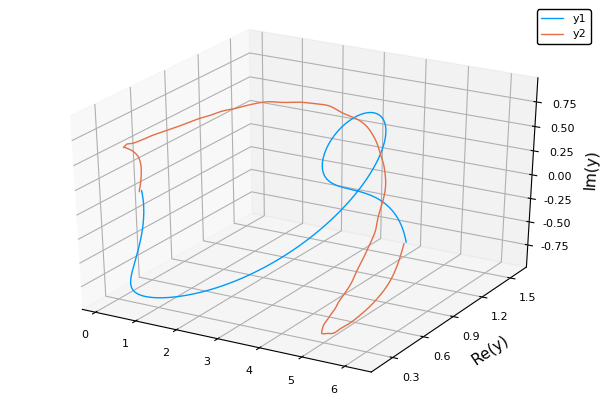

In [349]:

plot(Theta, [z_crossspect_sigpred_ana.(Z) z_crossspect_sigpred_num.(Z)])

In [327]:
M_out = 513; par = 55; Nex = 2^10;

# function wiener_filter_Nu(pred, sig, M_out = 513; par::Int64 = 55, Nex::Int64 = 2^10)
M = par
R_pred = autocov(pred,0:M)

#     Smoothing
LL = Int(floor(M/2))
lam1 = 1 .- 6*((0:LL)/M).^2 .+ 6*((0:LL)/M).^3
lam2 = 2*(1 .- (LL+1:M)/M).^3
lam = [lam1; lam2]

R_pred = R_pred.*lam
l = Scalar_CKMS_c(R_pred)

z_crossspect_sigpred_num = z_crossspect(sig, pred, par, win = "Par")
z_spect_pred_minus_num(z) = sum([l[i+1]z^(-i) for i = 0:M])

z_spect_pred_minus_num (generic function with 1 method)

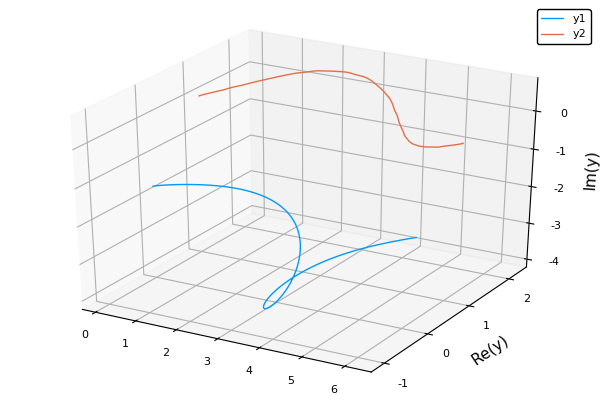

In [328]:
plot(Theta, [z_spect_pred_minus_ana.(Z) z_spect_pred_minus_num.(Z)])

In [329]:
z_spect_pred_plus_num(z) = -im.*z_spect_pred_minus_num(z)'

z_spect_pred_plus_num (generic function with 1 method)

In [330]:
S_sigpred_invS_plus_num = z_crossspect_sigpred_num.(Z)./z_spect_pred_plus_num.(Z)
S_sigpred_invS_plus_ana(z) = 25/3*sqrt(8/17*rr*rrho+0im)*(1-5/4*z+3/8*z^2)/((rho1 - z^(-1))*(rho2 - z^(-1))*(r1 - z)*(r2 - z));
S_sigpred_invS_plus_ANA = z_crossspect_sigpred_ana.(Z)./z_spect_pred_plus_ana.(Z)


alp = S_sigpred_invS_plus_num[1]/S_sigpred_invS_plus_ana.(Z)[1]

plot(Theta, [S_sigpred_invS_plus_num conj.(S_sigpred_invS_plus_ana.(Z)])

LoadError: syntax: unexpected "]" in argument list

In [331]:
S_sigpred_invS_plus_fft_num = fft(z_crossspect_sigpred_num.(Z)./z_spect_pred_plus_num.(Z))/Nex

Nexh = Int(floor(Nex/2))
S_sigpred_invS_plus_fft_plus_num = [S_sigpred_invS_plus_fft_num[1]; zeros(Nexh - 1); S_sigpred_invS_plus_fft_num[Nexh + 1:end]];

S_sigpred_invS_plus_plus_num = ifft(S_sigpred_invS_plus_fft_plus_num)*Nex;

H_num = S_sigpred_invS_plus_plus_num ./ z_spect_pred_minus_num.(Z)

h_num_raw = fft(H_num)/Nex;

h_num = [h_num_raw[1]; reverse(h_num_raw)[1:Nexh]]
h_num[1:M_out]
# end

513-element Array{Complex{Float64},1}:
  -1.139259314057034e-18 + 0.1684268217103253im   
  -0.0007623603535477053 - 0.2487327294324014im   
 -0.00034095645784565734 - 0.055620831604107704im 
  -0.0001524455071085429 - 0.016578877695823897im 
   -9.330040407265635e-5 - 0.007609844219028175im 
  -5.8396648225958663e-5 - 0.003810288931171816im 
  -4.4023518941199225e-5 - 0.0023936383552174813im
  -3.2628276976048976e-5 - 0.0015205596070927796im
   -2.004866279776465e-5 - 0.0008174898510440828im
  -3.5761569773650975e-5 - 0.001296098129570921im 
   -3.714822180415304e-5 - 0.0012116466902131256im
   -4.067834239866136e-5 - 0.0012060906771564923im
   -3.195658281902048e-5 - 0.0008684747348204804im
                         ⋮                        
     6.50451914367487e-6 + 2.2936066872347278e-7im
   6.5043916515687236e-6 + 2.093977245810763e-7im 
    6.504248273646205e-6 + 1.894390383758969e-7im 
    6.504086305329466e-6 + 1.694843096175628e-7im 
    6.503902271457372e-6 + 1.49533253543873

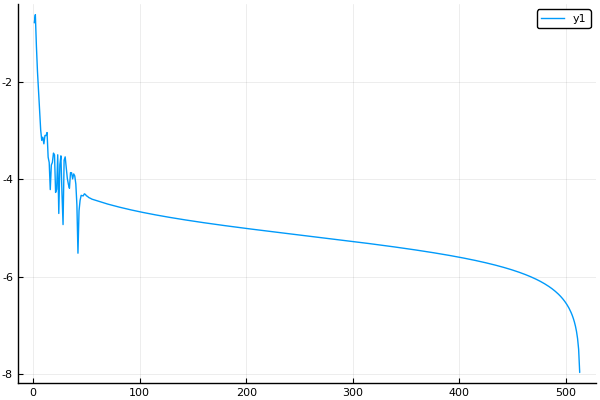

In [332]:
h = real.(h);
plot(log.(abs.(h))/log(10))

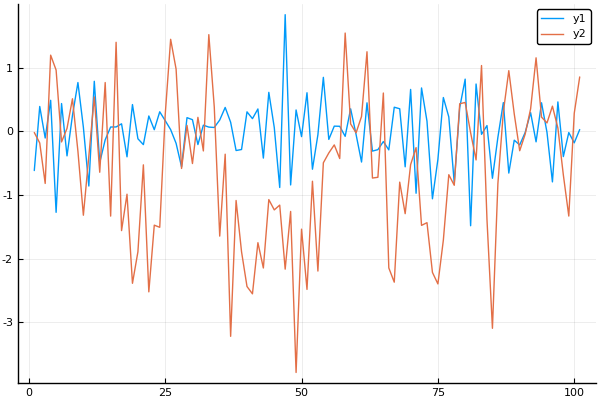

In [333]:
start = steps - 2*discard - 100
stop = steps - 2*discard
tim = start : stop

plot([sig_hat[tim] sig[tim]])

### Estimated Signal by Wiener Filter

In [334]:
sig_hat = conv(h,pred_test)[discard + 1:steps-discard];

In [335]:
Error = sig_hat .- sig_test[discard + 1:steps-discard];

Absolute mean square error: 0.9649012865199028

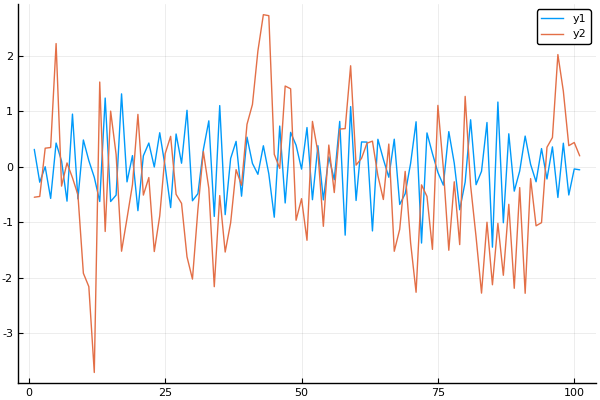

In [336]:
print("Absolute mean square error: ",mean(abs.(Error)))

plot([sig_hat[tim] sig_test[tim]])

### Test Orthogonality with Predictors

The Wiener filter, by virture of it being a least squares estimator will produce a prediction errors $Y_n - \hat{Y}_n$ -> `sig[n] - sig_hat[n]` that is uncorrolated with the predictors used $X_m$ -> `pred[m]` for $m \le n$. 

       Before lag = 0          |      after lag = 0 
mean:     -0.12573946296116575 | mean:     0.0541988114936332
variance: 0.06553224214714957 | variance: 0.036356148881374464

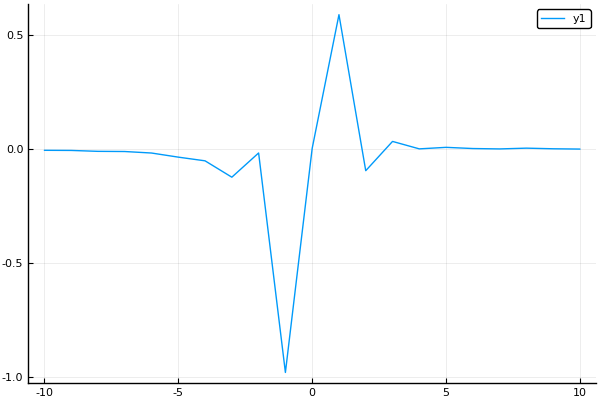

In [337]:
lag = 10
lags = -lag:lag

C = crosscov(Error,pred_test[discard + 1:steps-discard],lags);
print("       Before lag = 0          |      after lag = 0 ",
    "\nmean:     ", mean(C[1:lag]), " | mean:     ", mean(C[lag+2:end]),
    "\nvariance: ", var(C),         " | variance: ", var(C[lag+2:end]))
plot(lags,C)